In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [2]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

### Load Data

In [3]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
interv_df = pd.read_csv('outputs/interventions.csv')
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')
pilot_trans_df_small = pd.read_csv('outputs/pilot_transitions.csv')
pilot_trans_df = pd.read_csv('outputs/pilot_transitions_5months.csv')

In [4]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Get Transition Probabilities

In [5]:
def get_transition_probabilities(beneficiaries, transitions, min_support=5):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}
user_probs, sup = get_transition_probabilities([pilot_user_ids[0]], pilot_trans_df)

all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm.tqdm(pilot_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], pilot_trans_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23008/23008 [03:31<00:00, 108.95it/s]


In [6]:
print('Non-missing passive tuples (on which clustering can happen)')
print(all_probs[(~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())].shape)   
all_probs = pd.merge(all_probs, df[['user_id', 'cluster']])


Non-missing passive tuples (on which clustering can happen)
(10159, 9)


### Visualize 
### Pilot study classifier's predicted clusters VS actual probs

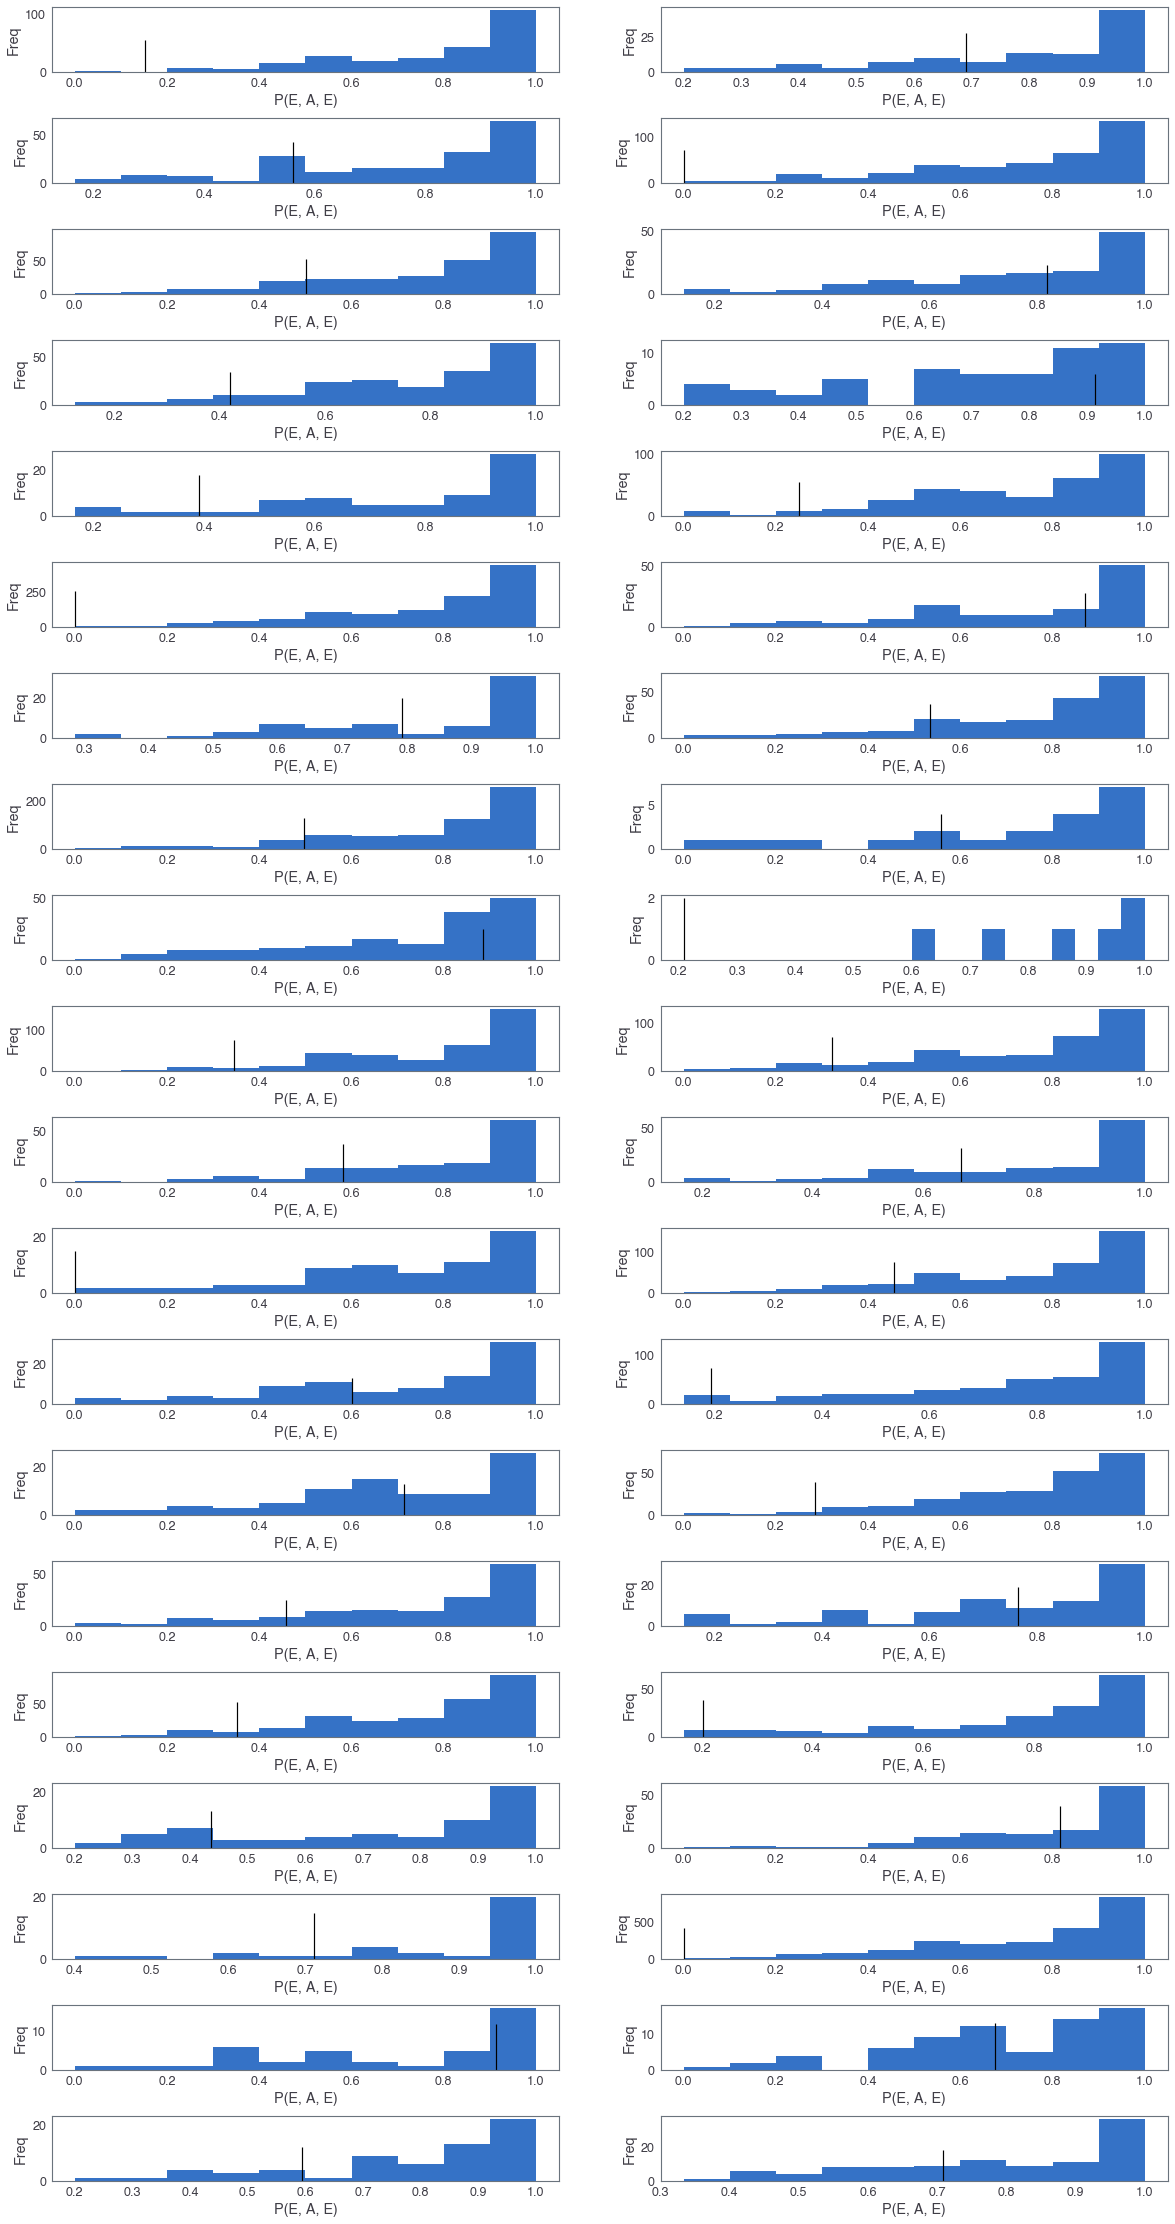

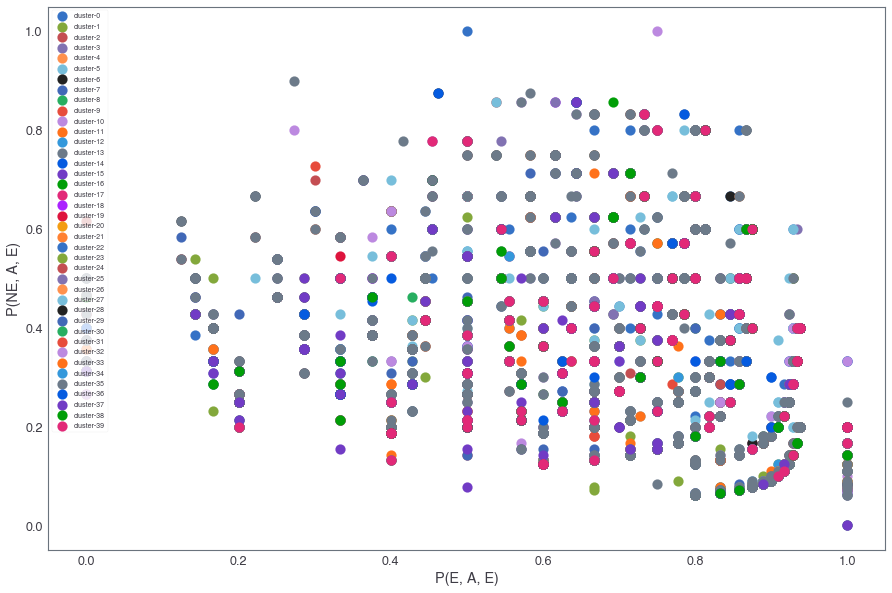

In [8]:
plt.figure(figsize=(20,40))
for cluster in range(40):
    plt.subplot(20, 2, cluster+1)
    plt.hist(all_probs[(all_probs['cluster']==cluster) &
                         (~all_probs.user_id.isin(interv_df.user_id))]['P(L, N, L)'])
    pred_prob = cluster_transition_probabilities[cluster_transition_probabilities.cluster==cluster]['P(E, A, E)'] 
#     print(pred_prob)
    ymax = all_probs[(all_probs['cluster']==cluster) &
                         (~all_probs.user_id.isin(interv_df.user_id))]['P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
    plt.grid(b=None)
    plt.xlabel('P(E, A, E)')
    plt.ylabel('Freq')
    plt.subplots_adjust(
                    hspace=0.7, 
                    )
plt.show()

import seaborn as sns
plt.figure(figsize=(15, 10))
for cluster in range(40):
    plt.scatter(all_probs[all_probs['cluster']==cluster]['P(L, N, L)'],
                all_probs[all_probs['cluster']==cluster]['P(H, N, L)'],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)

### Define kmeans-missing algo

### Clustering freshly on Complete Dataset


In [54]:
from sklearn.cluster import KMeans
from clustering import kmeans_missing
import numpy as np

USE_KMEANS_MISSING = True
n_clusters = 40

if USE_KMEANS_MISSING:
    X = all_probs[['P(L, N, L)', 'P(H, N, L)']]
    out =  kmeans_missing(X, n_clusters) 
    labels, centroids, X_hat, kmeans_new, _, _ = out
    X = pd.DataFrame(X_hat, columns=X.columns)
else:
    X = all_probs[['P(L, N, L)', 'P(H, N, L)']].dropna()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

X['fitted_cluster'] = labels



/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warn

### Visualize spread around centroids within a cluster

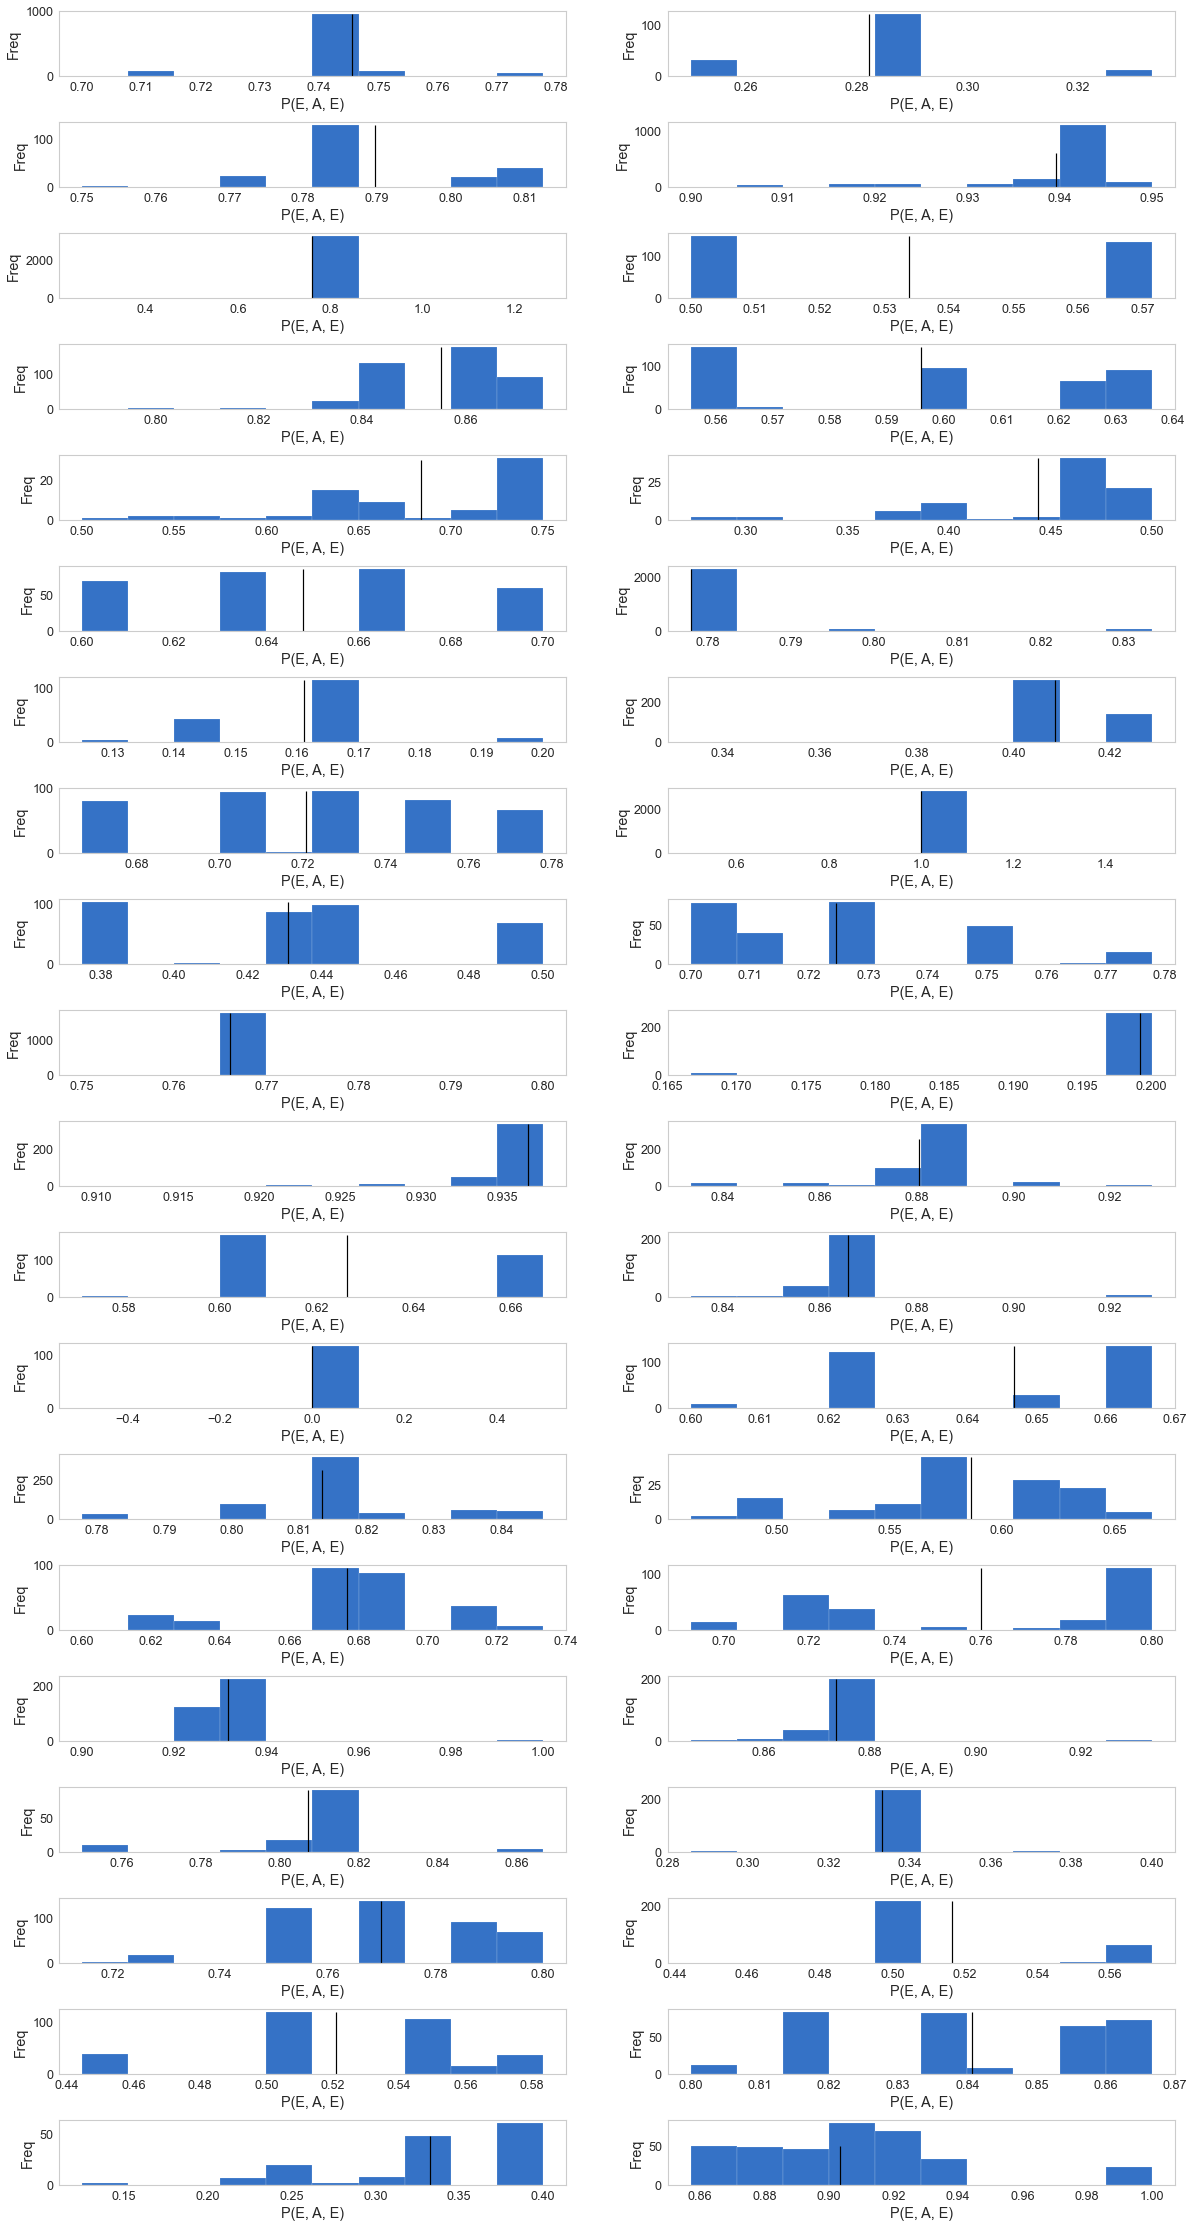

(23003, 3)


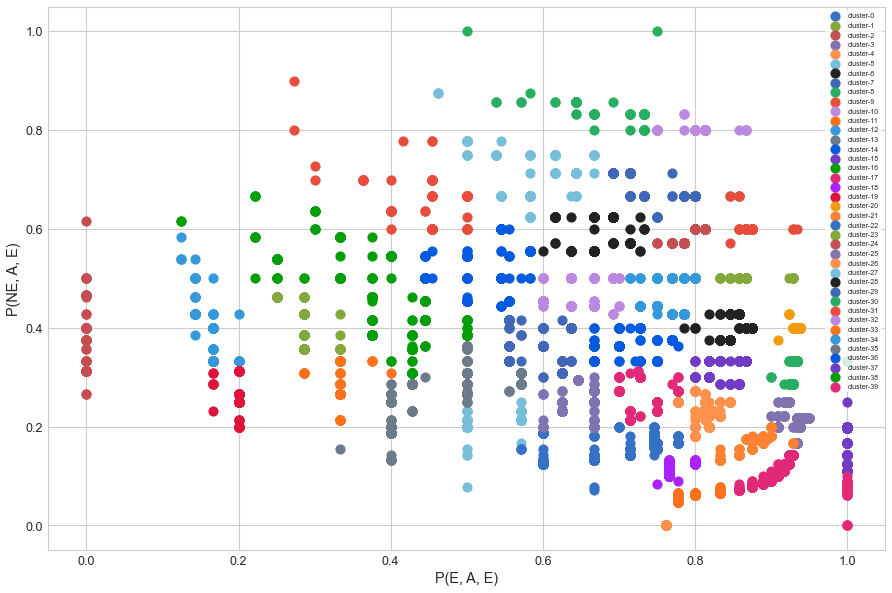

In [40]:
plt.figure(figsize=(20,40))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(X[X.fitted_cluster==cluster]['P(L, N, L)'])
    
    pred_prob = centroids[cluster, 0]
    
    ymax = X[X.fitted_cluster==cluster]['P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
    plt.xlabel('P(E, A, E)')
    plt.ylabel('Freq')
    plt.subplots_adjust(
                    hspace=0.7, 
                    )
plt.show()


import seaborn as sns
plt.figure(figsize=(15, 10))
print(X.shape)
for cluster in range(n_clusters):
    plt.scatter(X[X['fitted_cluster']==cluster].iloc[:, 0],
                X[X['fitted_cluster']==cluster].iloc[:, 1],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)
plt.show()

### Train-val split strategy

80 % 20% -> A, B

clustering on A -> ylabels

SPlit A in 80% and 20% we will get A_train, A_test

classifier is trained on A_train, tested on A_tested -> 7%

train classifier on full A
use classifier to predict cluster centres for B using B features
get probablities using predicted cluster centres

for B: predicted TP and true transition TP



## Train -val Split

In [244]:

warmup_states = pilot_trans_df.groupby('user_id').\
agg({'pre-action state':lambda x: list(x.replace({'H':0, 'L':1}))[:3]}).values
warmup_states = np.array(warmup_states.tolist())[:, 0, :]
warmup_state_df = pd.DataFrame(warmup_states, columns=['feat-44','feat-45', 'feat-46'])
warmup_state_df['user_id'] = pilot_trans_df.groupby('user_id')['user_id'].count().index.values


In [342]:
USE_KMEANS_MISSING = False
USE_WARMUP_STATES = True
n_clusters = 40
SPLIT_FRAC = 0.8

print(f'Initally {all_probs.shape[0]} data points')
if USE_KMEANS_MISSING:
    print('Using kmeans missing')
    probs = all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']]
else:
    print('Dropping missing passive probs points')
    probs = all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']].dropna()

feat_cols = [f'feat-{i}' for i in range(pilot_static_features.shape[1])]
feats = pd.DataFrame(pilot_static_features, columns=feat_cols)
feats['user_id'] = pilot_user_ids
data_df = pd.merge(probs,
                      feats)
if USE_WARMUP_STATES:
    data_df = pd.merge(data_df, warmup_state_df)
    feat_cols = [f'feat-{i}' for i in range(pilot_static_features.shape[1]+3)]

print(f'Modeling on {data_df.shape[0]} Data points ' )
n = data_df.shape[0]
shuffled = pd.Series(data_df.index).sample(frac=1).values
train_idx, test_idx = shuffled[:int(n*SPLIT_FRAC)],\
                               shuffled[int(n*SPLIT_FRAC):]
print('Train data points: ', len(train_idx))
print('Test data points: ', len(test_idx))

Initally 23003 data points
Dropping missing passive probs points
Modeling on 10159 Data points 
Train data points:  8127
Test data points:  2032


### CLustering on Train

In [343]:
from sklearn.cluster import KMeans
from clustering import kmeans_missing
import numpy as np

COLS_FOR_KMEANS = ['P(L, N, L)', 'P(H, N, L)']

X = data_df.loc[train_idx]
X_feat = data_df.loc[train_idx][feat_cols]

if USE_KMEANS_MISSING:
    out =  kmeans_missing(X[COLS_FOR_KMEANS], n_clusters) 
    labels, centroids, X_hat, kmeans_new, _, _ = out
    X[COLS_FOR_KMEANS] = X_hat
else:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X[COLS_FOR_KMEANS])
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

X['fitted_cluster'] = labels



In [344]:
prob_cols = [i for i in all_probs.columns if i.startswith('P')]
new_cluster_transition_probabilities = pd.DataFrame(columns=['count', 'cluster'] + prob_cols)

for i in range(n_clusters):
    cluster_beneficiaries = X[X['fitted_cluster'] == i]
    cluster_b_user_ids = cluster_beneficiaries['user_id']
    probs, _ = get_transition_probabilities(cluster_b_user_ids, pilot_trans_df, min_support=3)
    probs['cluster'] = i
    probs['count'] = len(cluster_b_user_ids)
    new_cluster_transition_probabilities = new_cluster_transition_probabilities.append(probs, ignore_index=True)

### Visualize Train Clustering and Spread around Centroids within a cluster

<Figure size 1440x3600 with 0 Axes>

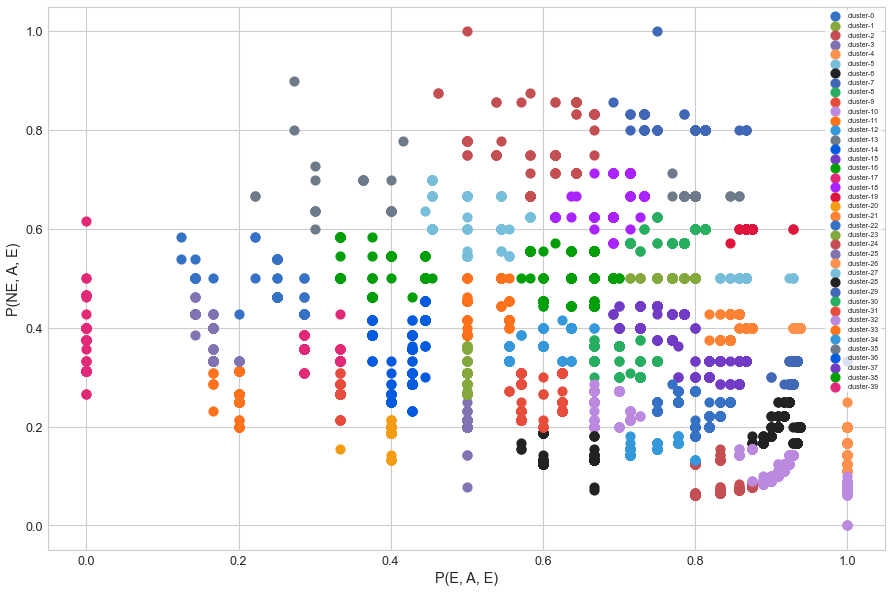

In [345]:
plt.figure(figsize=(20,50))
sns.set_style("whitegrid", {'axes.grid' : False})

# for cluster in range(n_clusters):
#     plt.subplot(20, 2, cluster+1)
#     plt.hist(X[X.fitted_cluster==cluster]['P(L, N, L)'])
#     pred_prob = new_cluster_transition_probabilities.loc[cluster, ['P(L, N, L)']]
    
#     ymax = X[X.fitted_cluster==cluster]['P(L, N, L)'].value_counts().max()
#     plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
#     plt.xlabel('P(E, A, E)', fontsize=10)
#     plt.ylabel('Freq')
#     plt.gca().set_title(f'Cluster-{cluster}')
#     plt.subplots_adjust(
#                     hspace=0.8, 
#                     )

# plt.show()

import seaborn as sns
plt.figure(figsize=(15, 10))
for cluster in range(n_clusters):
    plt.scatter(X[X['fitted_cluster']==cluster][COLS_FOR_KMEANS[0]],
                X[X['fitted_cluster']==cluster][COLS_FOR_KMEANS[1]],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)

### Learn Random Forest Classifier, get CV score

In [353]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X_feat, X['fitted_cluster']):
    dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)
#     dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=7, n_jobs=-1, random_state=124)
#     dt_clf = LGBMClassifier(n_estimators=200, max_depth=5)
    dt_clf.fit(X_feat.iloc[train_index, :-3], X.iloc[train_index]['fitted_cluster'])
    print('test acc: ', dt_clf.score(X_feat.iloc[test_index, :-3], X.iloc[test_index]['fitted_cluster']), \
    'train acc: ', dt_clf.score(X_feat.iloc[train_index, :-3], X.iloc[train_index]['fitted_cluster']))

# dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)
dt_clf = LGBMClassifier(n_estimators=100, max_depth=3)
# dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)

# dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)
dt_clf.fit(X_feat.iloc[:, :-3], X['fitted_cluster'])


test acc:  0.05904059040590406 train acc:  0.13059529303184125
test acc:  0.042435424354243544 train acc:  0.12721119827718813
test acc:  0.046740467404674045 train acc:  0.12367328103368712
test acc:  0.04059040590405904 train acc:  0.12767266574373173
test acc:  0.046125461254612546 train acc:  0.12121212121212122


LGBMClassifier(max_depth=3)

### Get predicted clusters, predicted probs, metrics

In [354]:
pred_clusters = dt_clf.predict(data_df.loc[test_idx, feat_cols[:-3]])
print('unique predicted clusters: ', np.unique(pred_clusters))

pred_probs = new_cluster_transition_probabilities.loc[pred_clusters, ['cluster']+COLS_FOR_KMEANS]   
tru_probs = data_df.iloc[test_idx][COLS_FOR_KMEANS]

print('RMSE from our classifier')
diff = (tru_probs[COLS_FOR_KMEANS] - pred_probs[COLS_FOR_KMEANS])
print(np.sqrt(np.square(diff).mean(axis=0)))
print()
print('RMSE from Random Classifier')
diff = tru_probs[COLS_FOR_KMEANS] - np.random.uniform(0, 1, tru_probs.shape)
print(np.sqrt(np.square(diff).mean(axis=0)))


unique predicted clusters:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
RMSE from our classifier
P(L, N, L)    0.172377
P(H, N, L)    0.131934
dtype: float64

RMSE from Random Classifier
P(L, N, L)    0.411276
P(H, N, L)    0.358521
dtype: float64


In [300]:
7+ 27, 9+ 18

38+15, 36+15

46+20, 45+23

38+26, 10+6

22+8, 20+9

28+47, ,28+47
4.8+9.3, 4.2+9.2
17+13, 16+13


(34, 27)

In [355]:
pred_probs

,cluster,"P(L, N, L)","P(H, N, L)"
26,26.0,1.000000,0.186176
2,2.0,0.839054,0.076375
22,22.0,0.809418,0.231559
26,26.0,1.000000,0.186176
26,26.0,1.000000,0.186176
...,...,...,...
22,22.0,0.809418,0.231559
26,26.0,1.000000,0.186176
6,6.0,0.921182,0.203642
16,16.0,0.646015,0.498306


In [356]:
tru_probs

,"P(L, N, L)","P(H, N, L)"
7665,0.500000,0.200000
8877,0.625000,0.230769
9355,1.000000,0.200000
1481,0.700000,0.400000
3553,0.571429,0.285714
...,...,...
9013,0.400000,0.187500
8155,0.857143,0.428571
4006,0.571429,0.214286
7458,0.937500,0.400000


### Visualize Spread in Validation data True Probablity, within assigned cluster

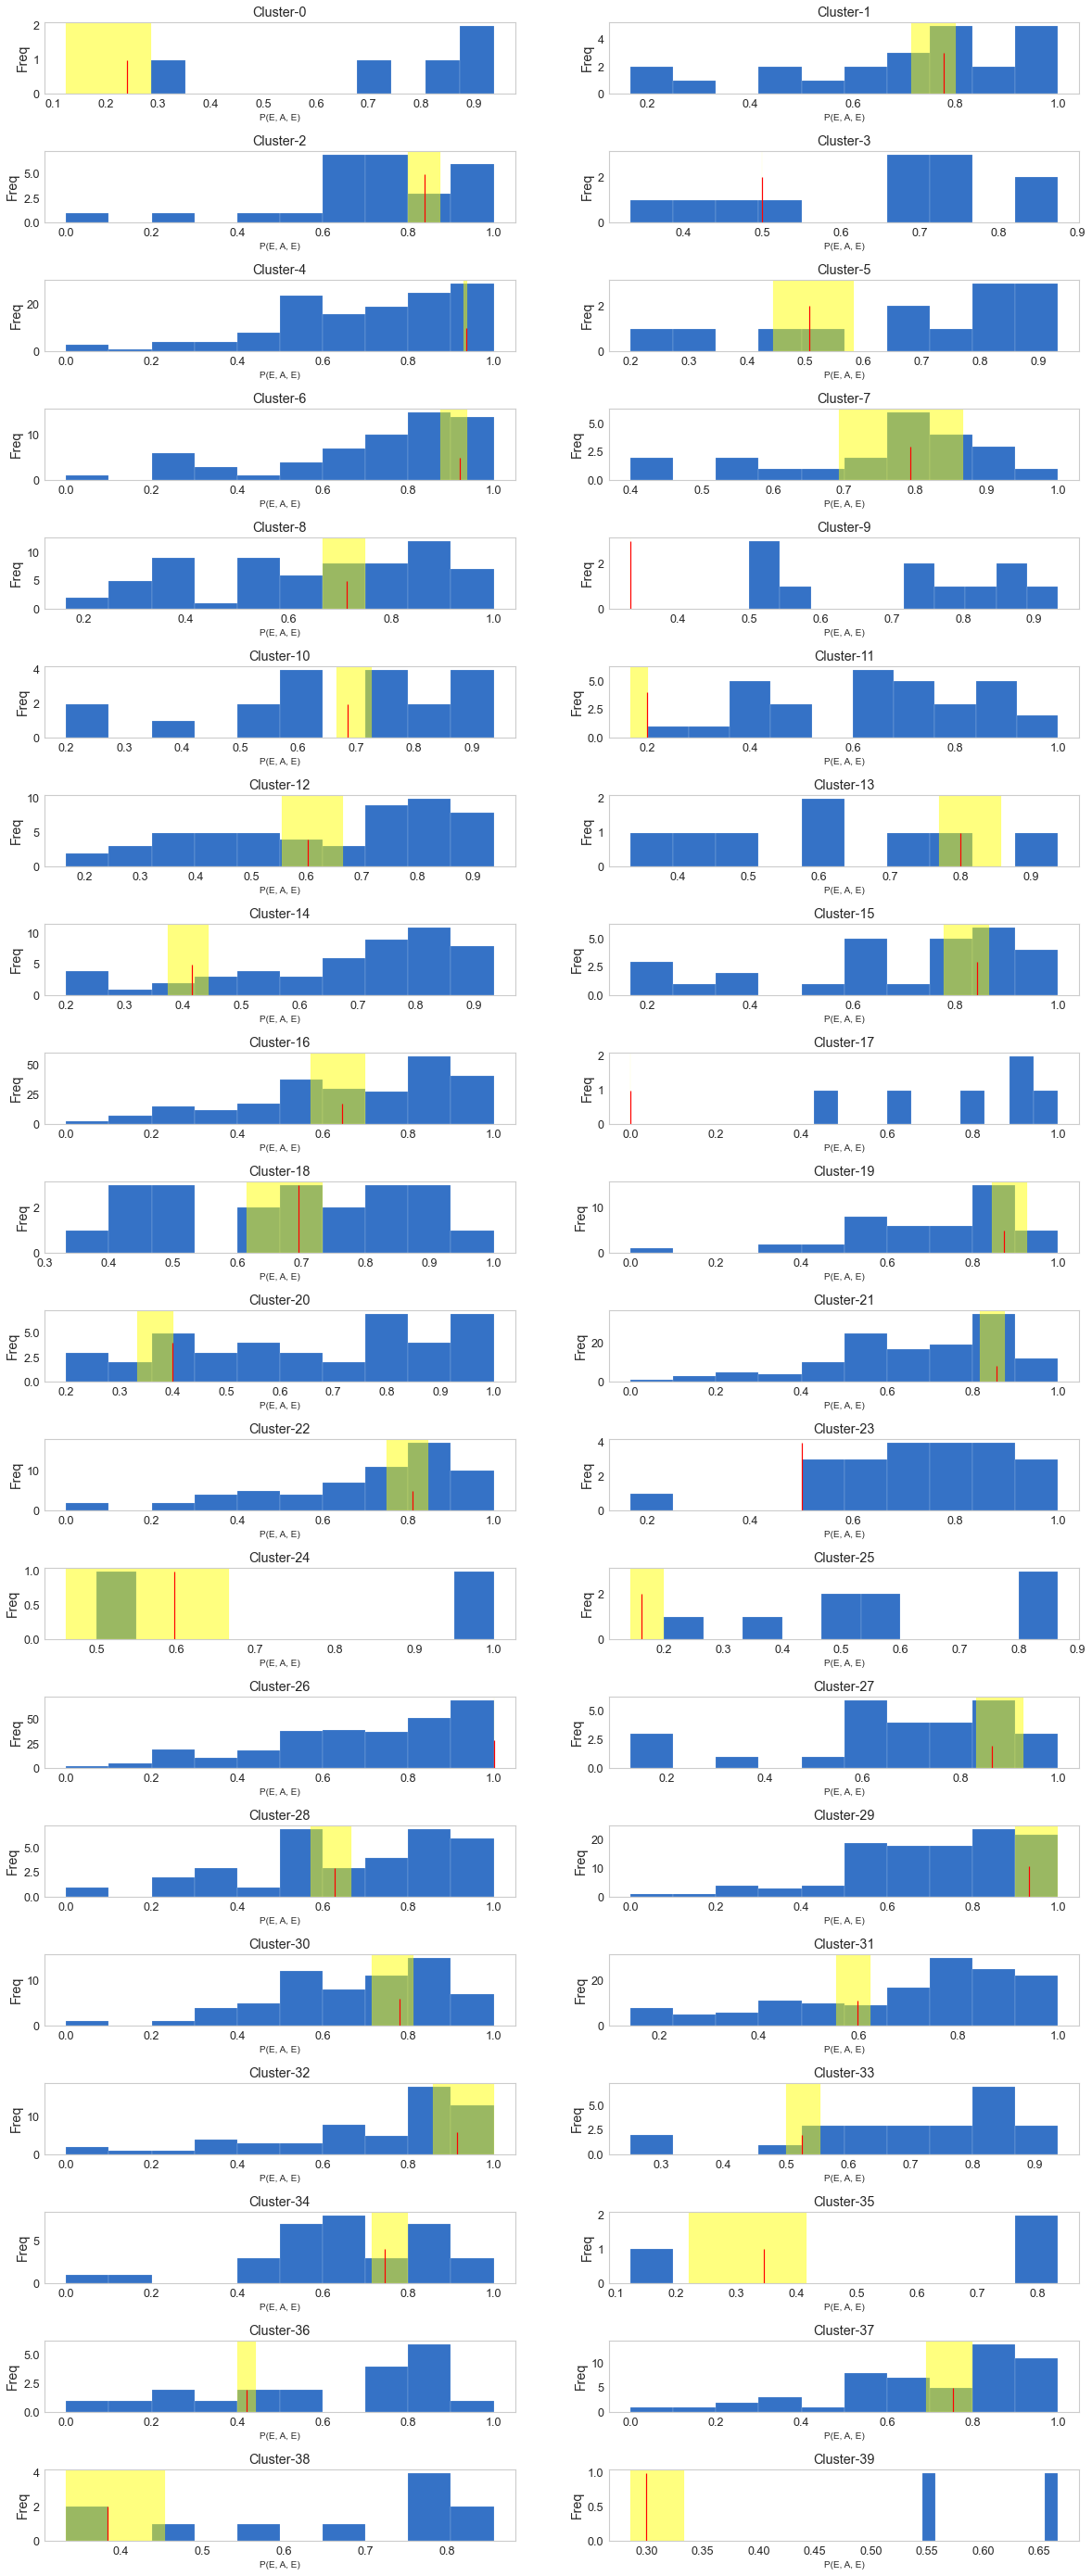

In [357]:
plot_df = pred_probs.rename(columns={'cluster':'fitted_cluster'})
plot_df['tru-P(L, N, L)'] = tru_probs.iloc[:, 0].values
plot_df['tru-P(H, N, L)'] = tru_probs.iloc[:, 1].values


plt.figure(figsize=(20,50))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(plot_df[plot_df.fitted_cluster==cluster]['tru-P(L, N, L)'])
    try:
        pred_prob = plot_df[plot_df.fitted_cluster==cluster]['P(L, N, L)'].iloc[0]
    except:
        print(f'Cluster {cluster} was never predicted, skipping')
        continue
    ymax = plot_df[plot_df.fitted_cluster==cluster]['tru-P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='red')

    plt.axvspan(xmin=X[X.fitted_cluster==cluster]['P(L, N, L)'].min(),
               xmax=X[X.fitted_cluster==cluster]['P(L, N, L)'].max(),
               ymin=0, ymax=ymax, alpha=0.5, color='yellow')
    plt.xlabel('P(E, A, E)', fontsize=10)
    plt.ylabel('Freq')
    plt.gca().set_title(f'Cluster-{cluster}')
    plt.subplots_adjust(
                    hspace=0.8, 
                    )
plt.show()